In [26]:
import importlib
import data 
importlib.reload(data)

<module 'data' from 'c:\\Users\\janav\\Documents\\load forecasting\\local-stlf\\interformer\\data.py'>

In [27]:
import torch
from data import preprocess_all

In [28]:
condition_df = preprocess_all(
    "data/mm79158.csv",
    "data/slovenia_hourly_weather.csv",
    "data/slovenian_holidays_2016_2018.csv"
)



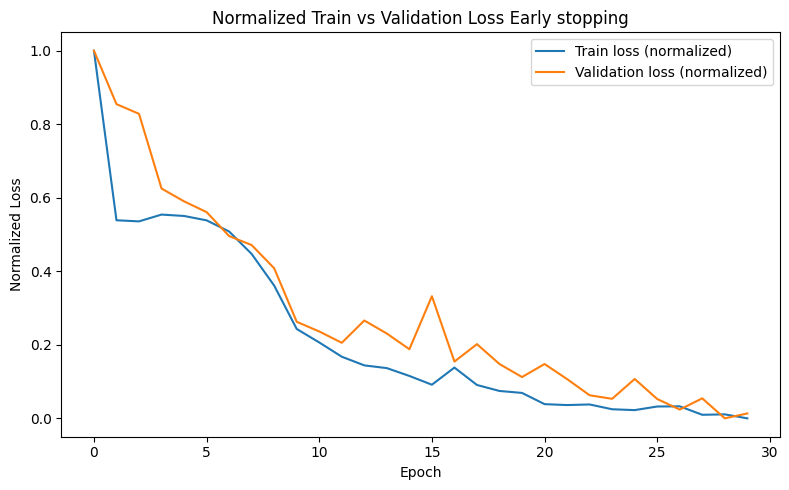

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('logs/log_trial2_lr0.0001_clip0.1_bs256_dropout0.2_dmodel128_layers2_heads1_kernel4.csv')

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

plt.figure(figsize=(8, 5))
plt.plot(df['train_loss_norm'].values, label="Train loss (normalized)", )
plt.plot(df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss Early stopping")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# === Config ===
INPUT_LEN = 24            # e.g., 1 day hourly
FORECAST_LEN = 12         # e.g., 12 hours
QUANTILES = [0.1, 0.5, 0.9]
TRIALS = 5
EPOCHS = 30

# === Device Setup ===
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)

MODEL_PATH = 'models/model_trial4_lr0.001_clip1_bs128_dropout0_dmodel64_layers4_heads8_kernel4.pth'
model = torch.load(MODEL_PATH)

CUDA available: True
Using GPU: NVIDIA GeForce RTX 4060


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\2851512208.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


In [30]:
condition_df = preprocess_all(
    "data/mm79158.csv",
    "data/slovenia_hourly_weather.csv",
    "data/slovenian_holidays_2016_2018.csv"
)

In [31]:
from data import prepare_interformer_dataloaders_and_prediction

In [32]:
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import matplotlib.pyplot as plt

def evaluate_model(model_path, test_loader, scaler_y, condition_df, quantile_index=1, device='cuda'):
    model.to(device)
    model.eval()

    y_true_all = []
    y_pred_all = []

    vred_index = list(condition_df.columns).index('vrednost')
    min_v = scaler_y.data_min_[vred_index]
    max_v = scaler_y.data_max_[vred_index]
    
    def invert_scaled(y):
        return y * (max_v - min_v) + min_v

    with torch.no_grad():
        for x_cond, x_pred, y in test_loader:
            x_cond, x_pred, y = x_cond.to(device), x_pred.to(device), y.to(device)

            # Predict
            preds, *_ = model(x_cond, x_pred)  # [B, Q, H]
            median_preds = preds[:, quantile_index, :]  # take median quantile

            # Move to CPU for metric eval
            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(median_preds.cpu().numpy())

    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)

    # Invert scaling
    y_true_all = invert_scaled(y_true_all)
    y_pred_all = invert_scaled(y_pred_all)

    # === Metrics
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
    rmse = root_mean_squared_error(y_true_all, y_pred_all)

    print(f"📉 Test MAE:  {mae:.4f}")
    print(f"📉 Test MAPE: {mape:.4f}")
    print(f"📉 Test RMSE: {rmse:.4f}")

    # === Plot first horizon
    plt.figure(figsize=(30, 7))
    plt.plot(y_true_all[:, 0], color='blue', label="True", linewidth=0.5)
    plt.plot(y_pred_all[:, 0], color='red', label="Predicted", linewidth=0.5)
    plt.xlabel("Sample")
    plt.ylabel("Rescaled Value")
    plt.title("Predicted vs True Values (first forecast step)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mae, mape, rmse


📦 Loading model_trial1_lr0.01_clip10_bs64_dropout0.2_dmodel64_layers8_heads1_kernel6.pth with batch_size=64


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\2894690782.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_dir, fname))


📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling features (x_cond, x_pred) and targets (y)...
📉 Test MAE:  1.5760
📉 Test MAPE: 0.6216
📉 Test RMSE: 2.4251


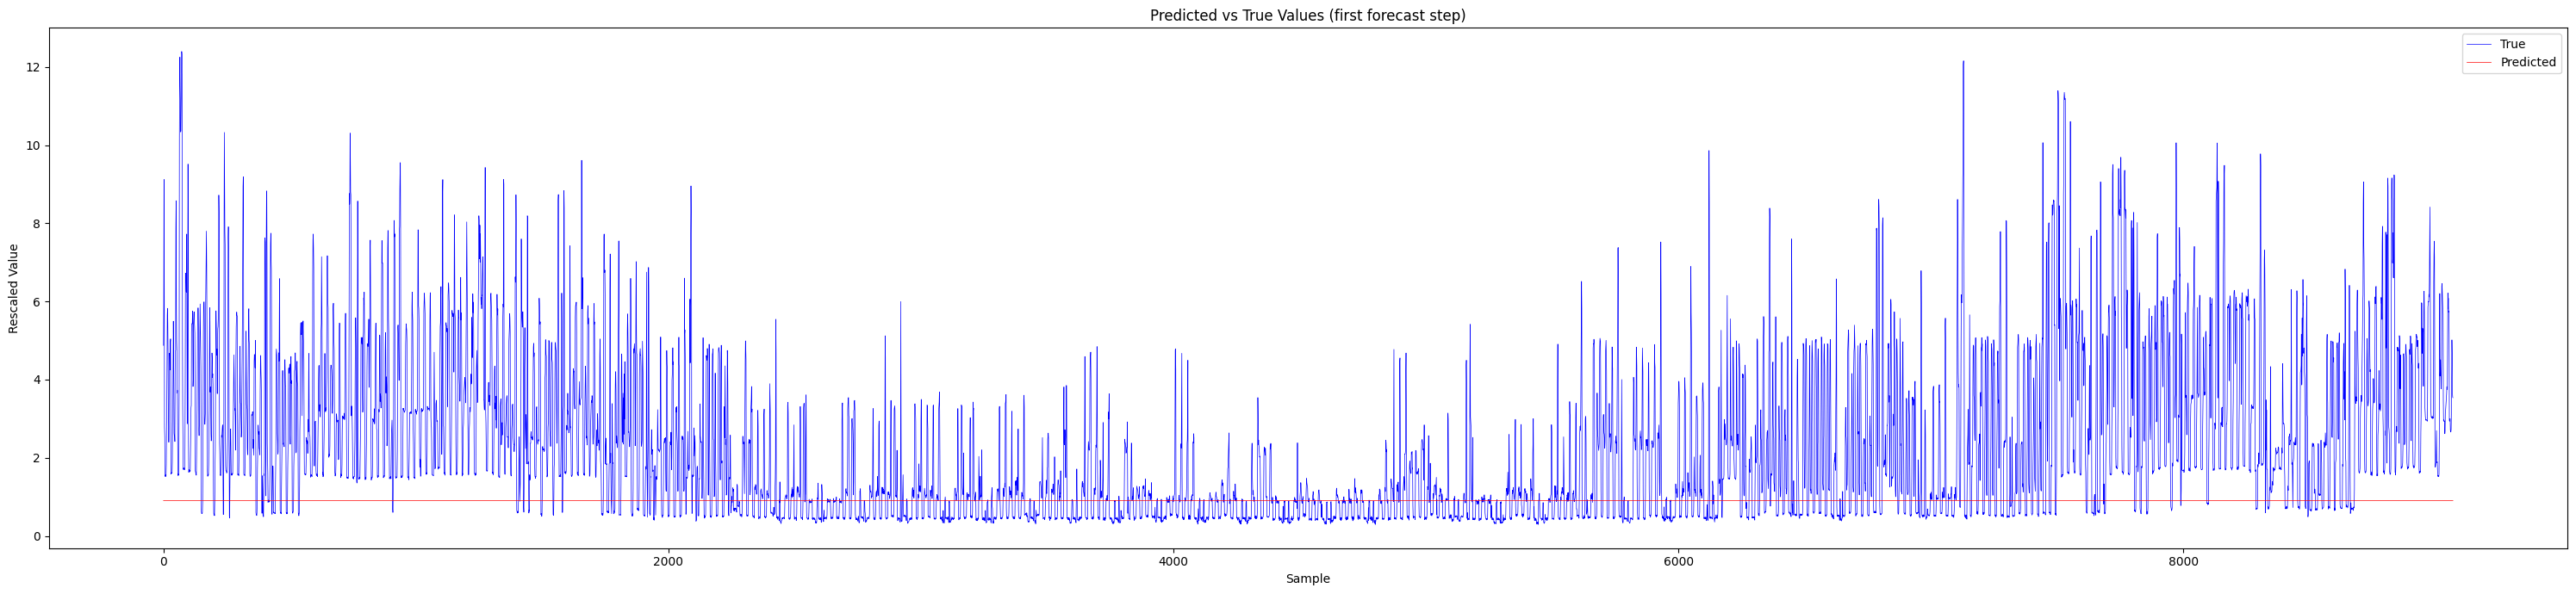

📦 Loading model_trial2_lr0.0001_clip0.1_bs256_dropout0.2_dmodel128_layers2_heads1_kernel4.pth with batch_size=256


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\2894690782.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_dir, fname))


📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling features (x_cond, x_pred) and targets (y)...
📉 Test MAE:  1.0756
📉 Test MAPE: 0.6013
📉 Test RMSE: 1.6345


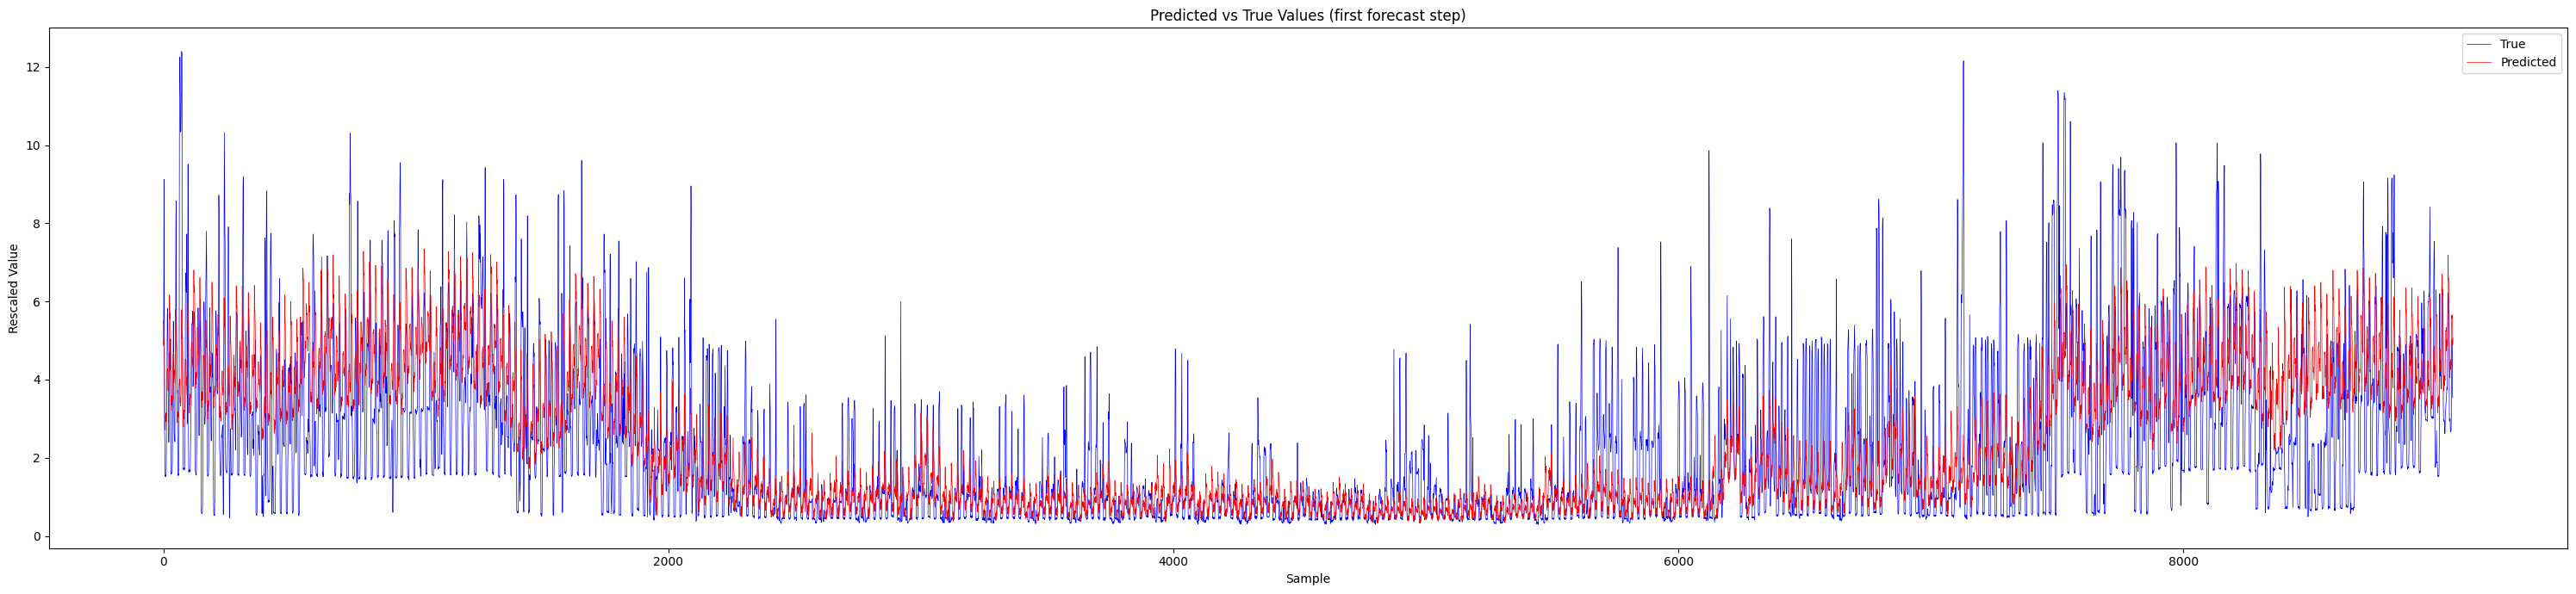

📦 Loading model_trial3_lr0.01_clip10_bs64_dropout0.15_dmodel128_layers4_heads4_kernel6.pth with batch_size=64


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\2894690782.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_dir, fname))


📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling features (x_cond, x_pred) and targets (y)...
📉 Test MAE:  1.5157
📉 Test MAPE: 0.6751
📉 Test RMSE: 2.3286


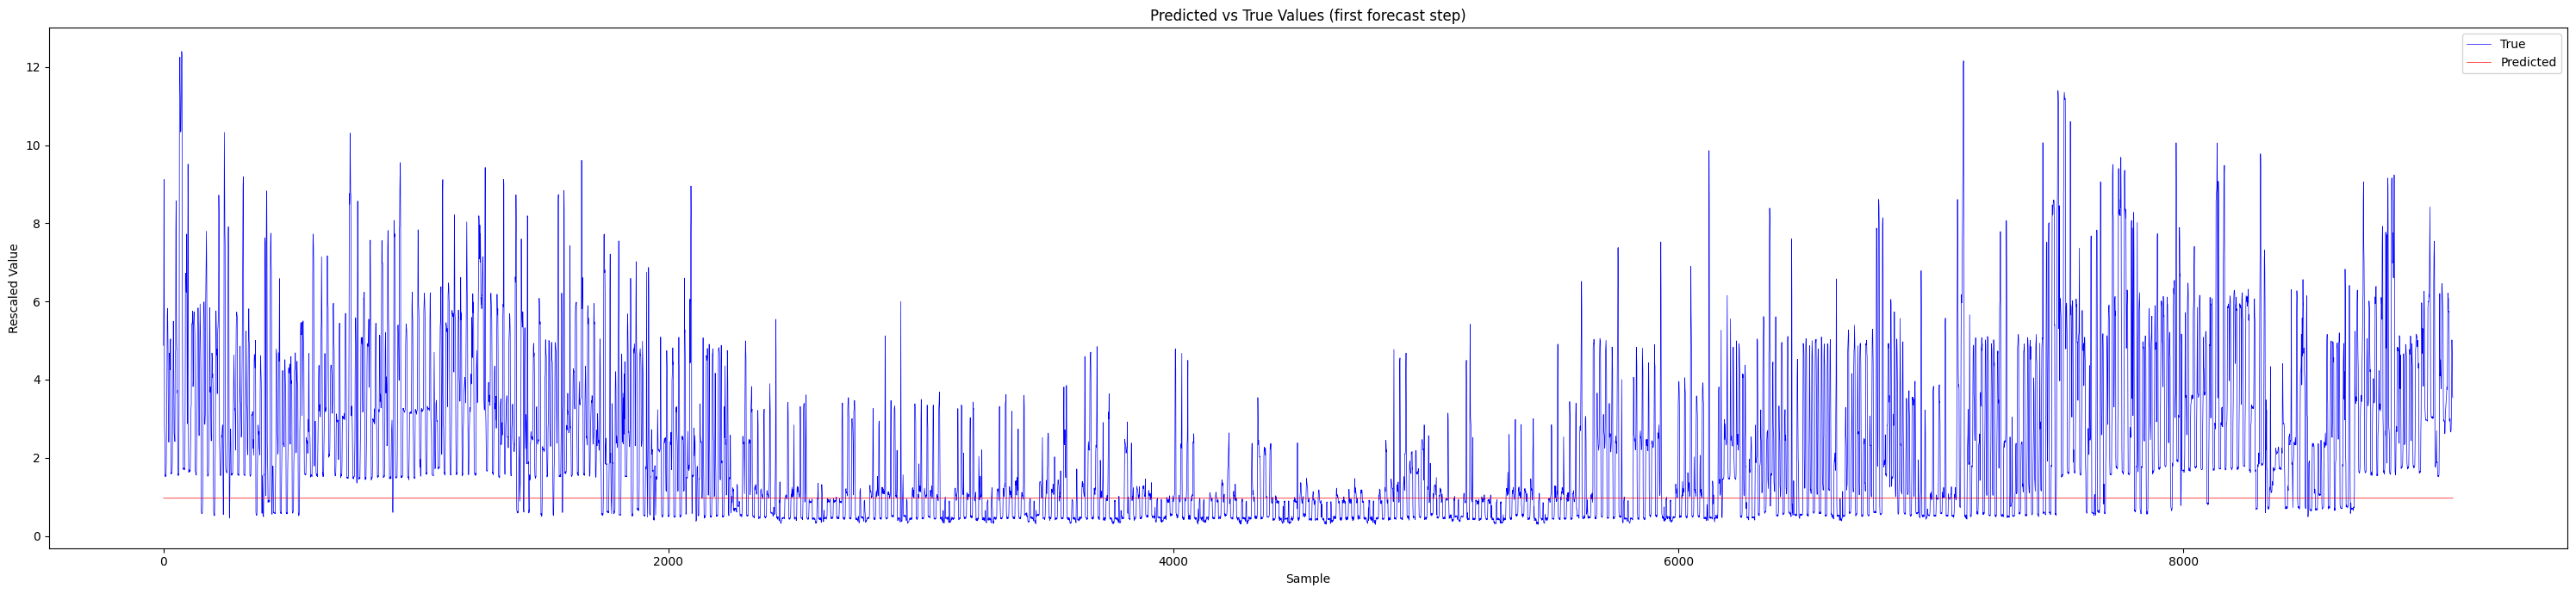

📦 Loading model_trial4_lr0.001_clip1_bs128_dropout0_dmodel64_layers4_heads8_kernel4.pth with batch_size=128


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\2894690782.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_dir, fname))


📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling features (x_cond, x_pred) and targets (y)...
📉 Test MAE:  1.5461
📉 Test MAPE: 0.5455
📉 Test RMSE: 2.4160


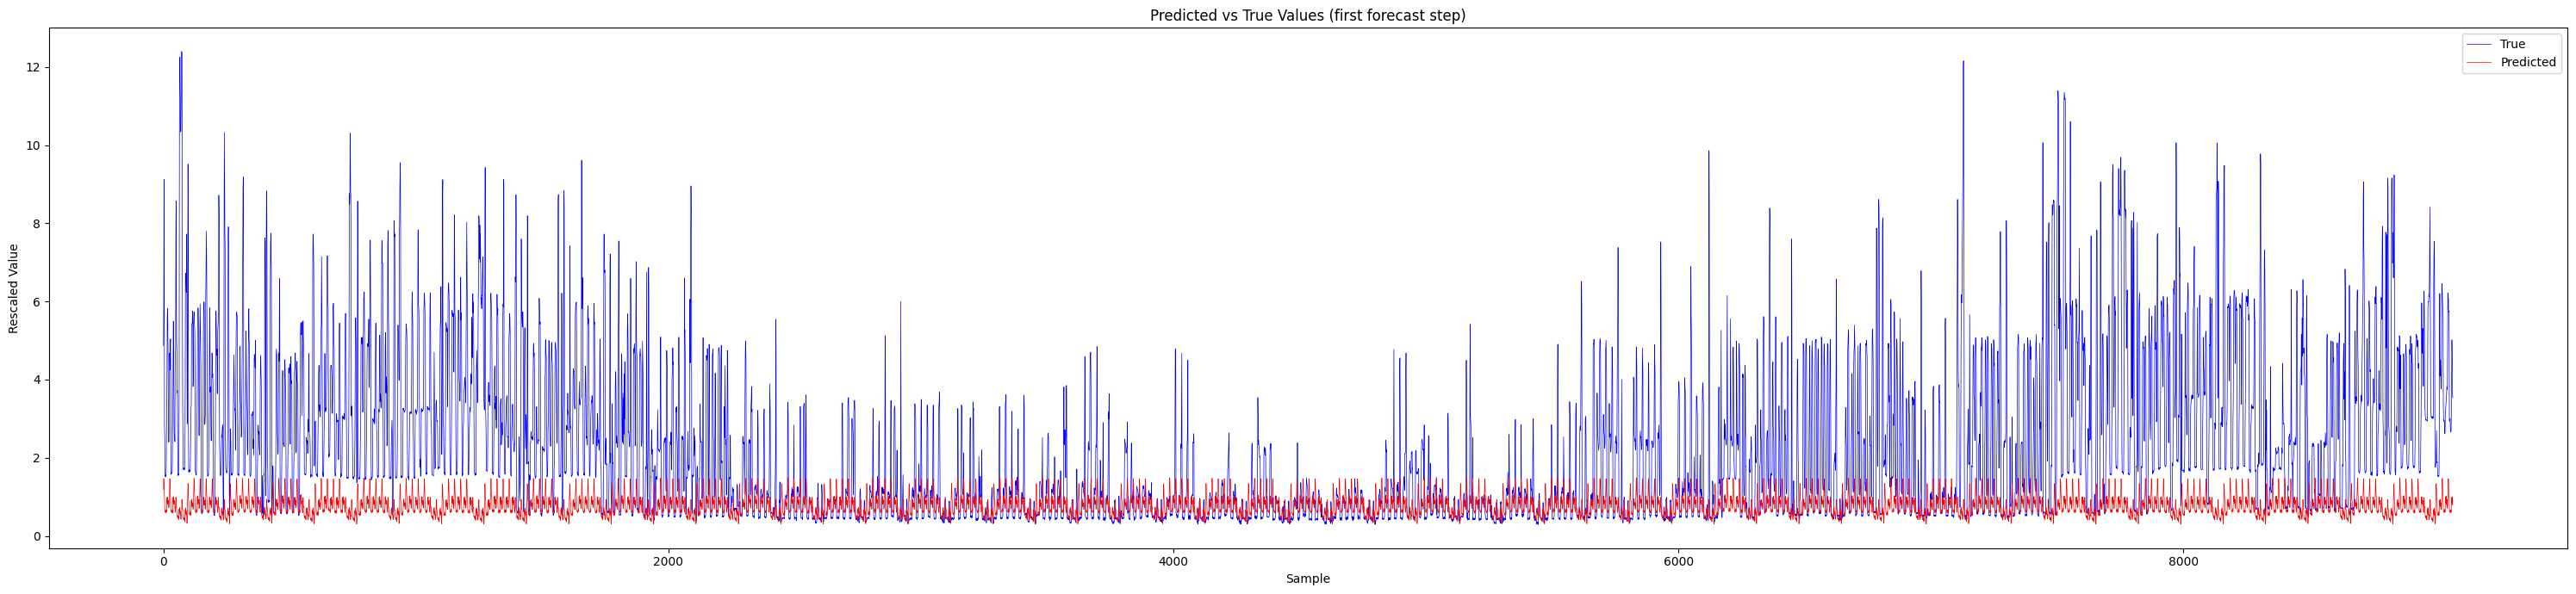

📦 Loading model_trial5_lr0.01_clip1_bs128_dropout0_dmodel32_layers2_heads8_kernel6.pth with batch_size=128


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\2894690782.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_dir, fname))


📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling features (x_cond, x_pred) and targets (y)...
📉 Test MAE:  1.5638
📉 Test MAPE: 0.6508
📉 Test RMSE: 2.3929


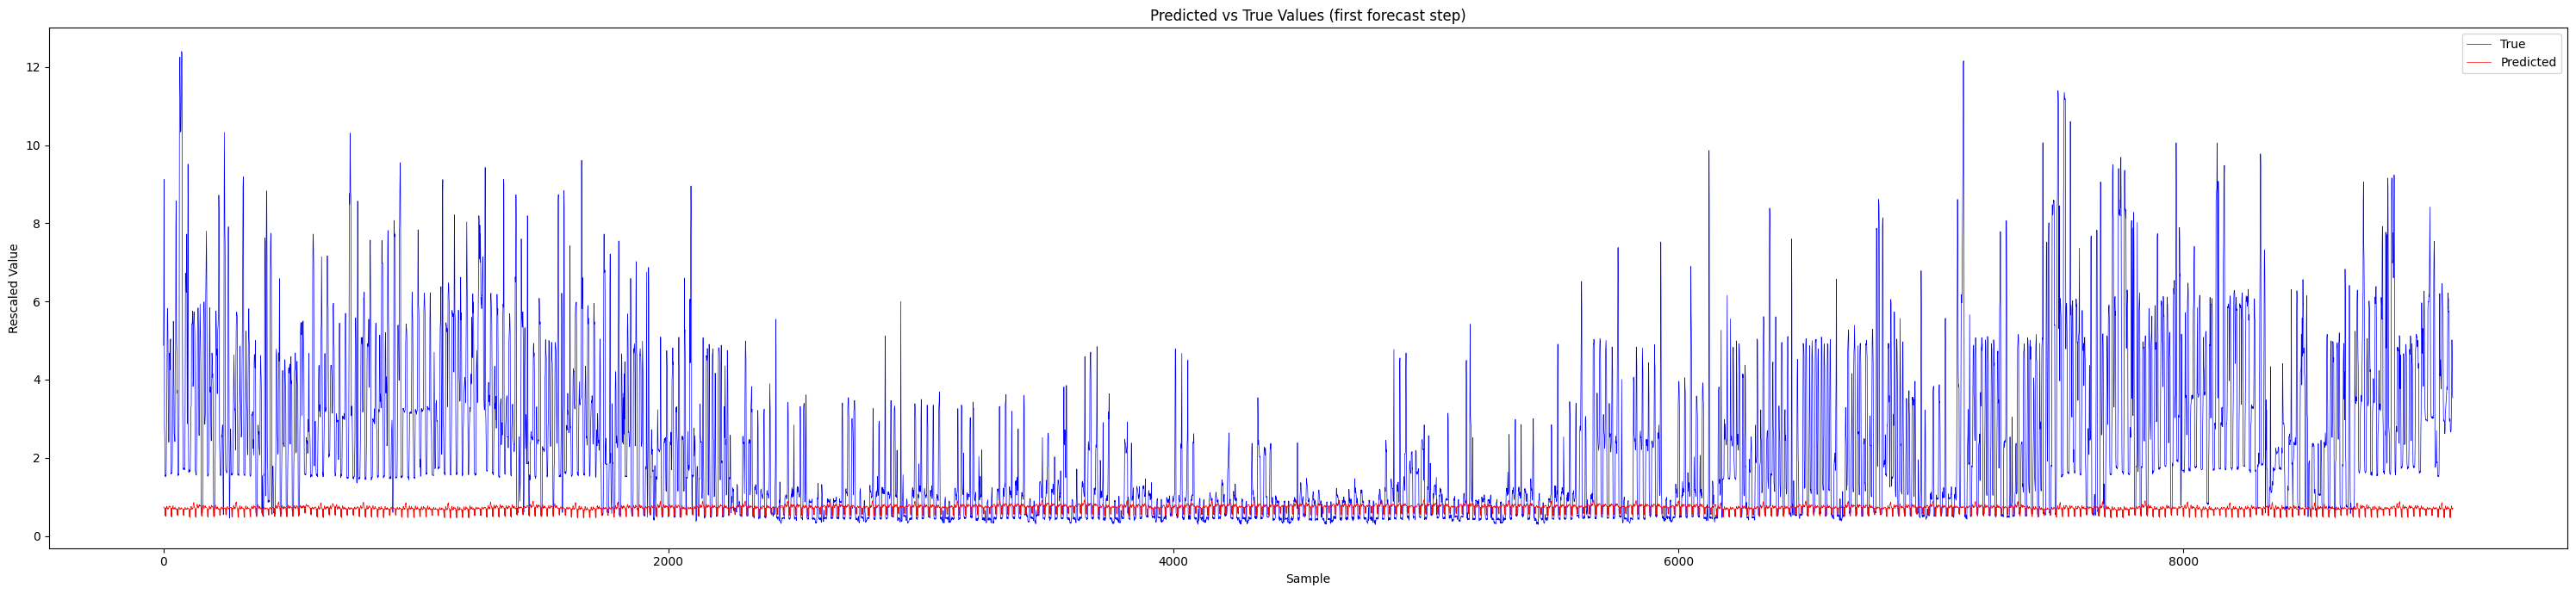

In [33]:
import os
import re
import torch

model_dir = 'models'
results = []

for fname in os.listdir(model_dir):
    if not fname.endswith('.pth'):
        continue

    # === Extract batch size from filename
    match = re.search(r'bs(\d+)', fname)
    batch_size = int(match.group(1)) if match else 256  # fallback default

    print(f"📦 Loading {fname} with batch_size={batch_size}")

    # === Load model
    model = torch.load(os.path.join(model_dir, fname))

    # === Prepare data
    train_loader, val_loader, test_loader, scaler_x, scaler_y = prepare_interformer_dataloaders_and_prediction(
        condition_df,
        input_len=INPUT_LEN,
        forecast_len=FORECAST_LEN,
        batch_size=batch_size
    )

    # === Evaluate
    mae, mape, rmse = evaluate_model(
        model, test_loader, scaler_y, condition_df,
        quantile_index=1, device='cuda'
    )

    results.append({
        'model': fname,
        'mae': mae, 
        'mape': mape,
        'rmse': rmse
    })
        
    
import pandas as pd

pd.DataFrame(results).to_csv('results.csv')


In [22]:
def autoregressive_evaluate_model(model, val_loader, test_loader, scaler_y, condition_df, forecast_len, quantile_index=1, device='cuda'):
    model.to(device)
    model.eval()

    # === Extract initial sequence from validation
    val_last = list(val_loader)[-1]
    x_cond, x_pred, _ = val_last
    x_cond = x_cond[0].unsqueeze(0).to(device)  # [1, input_len, F_cond]
    x_pred = x_pred[0].unsqueeze(0).to(device)  # [1, forecast_len, F_pred]

    # === Get vrednost index and scaling
    vred_index_cond = list(condition_df.columns).index('vrednost')  # for x_cond
    vred_index_pred = vred_index_cond - 1  # usually, x_pred has 1 less feature (no target)

    min_v = scaler_y.data_min_[vred_index_cond]
    max_v = scaler_y.data_max_[vred_index_cond]
    def invert_scaled(y): return y * (max_v - min_v) + min_v

    # === True targets from test set
    y_true_all = torch.cat([batch[2] for batch in test_loader], dim=0).cpu().numpy()
    y_pred_all = []

    total_steps = len(y_true_all)
    step = forecast_len
    current_step = 0

    with torch.no_grad():
        while current_step < total_steps:
            preds, *_ = model(x_cond, x_pred)  # [1, Q, H]
            pred_vals = preds[0, quantile_index, :]  # [H]
            y_pred_all.append(pred_vals.cpu().numpy())

            # Prepare new tensors by copying the current ones
            new_x_cond = x_cond[:, step:, :].clone()
            new_x_pred = x_pred[:, step:, :].clone()

            # Construct new prediction values only for the 'vrednost' column
            for i in range(step):
                if i >= pred_vals.shape[0]:  # handle edge
                    break
                val = pred_vals[i].item()
                new_x_cond = torch.cat([new_x_cond, x_cond[:, -1:, :].clone()], dim=1)
                new_x_cond[:, -1, vred_index_cond] = val

                new_x_pred = torch.cat([new_x_pred, x_pred[:, -1:, :].clone()], dim=1)
                new_x_pred[:, -1, vred_index_pred] = val

            x_cond = new_x_cond
            x_pred = new_x_pred
            current_step += step

    # === Final prediction stack
    y_pred_all = np.concatenate(y_pred_all, axis=0)[:total_steps]
    y_true_all = invert_scaled(y_true_all)
    y_pred_all = invert_scaled(y_pred_all)
    print(y_pred_all.shape, y_true_all.shape)
    y_true_all = y_true_all[:, 0]

    # === Metrics
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mape = mean_absolute_percentage_error(y_true_all, y_pred_all)
    rmse = root_mean_squared_error(y_true_all, y_pred_all)

    print(f"📉 Test MAE:  {mae:.4f}")
    print(f"📉 Test MAPE: {mape:.4f}")
    print(f"📉 Test RMSE: {rmse:.4f}")

    # === Plot
    plt.figure(figsize=(30, 7))
    plt.plot(y_true_all, label="True", linewidth=0.5, color='blue')
    plt.plot(y_pred_all, label="Predicted", linewidth=0.5, color='red')
    plt.xlabel("Step")
    plt.ylabel("Rescaled vrednost")
    plt.title("Autoregressive Forecast vs True")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mae, mape, rmse


C:\Users\janav\AppData\Local\Temp\ipykernel_35172\3149310547.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(MODEL_PATH)


📊 Dataset split → Train: 18138, Val: 3022, Test: 9068
🔃 Scaling features (x_cond, x_pred) and targets (y)...
(9068,) (9068, 12)
📉 Test MAE:  1.5699
📉 Test MAPE: 0.6426
📉 Test RMSE: 2.4131


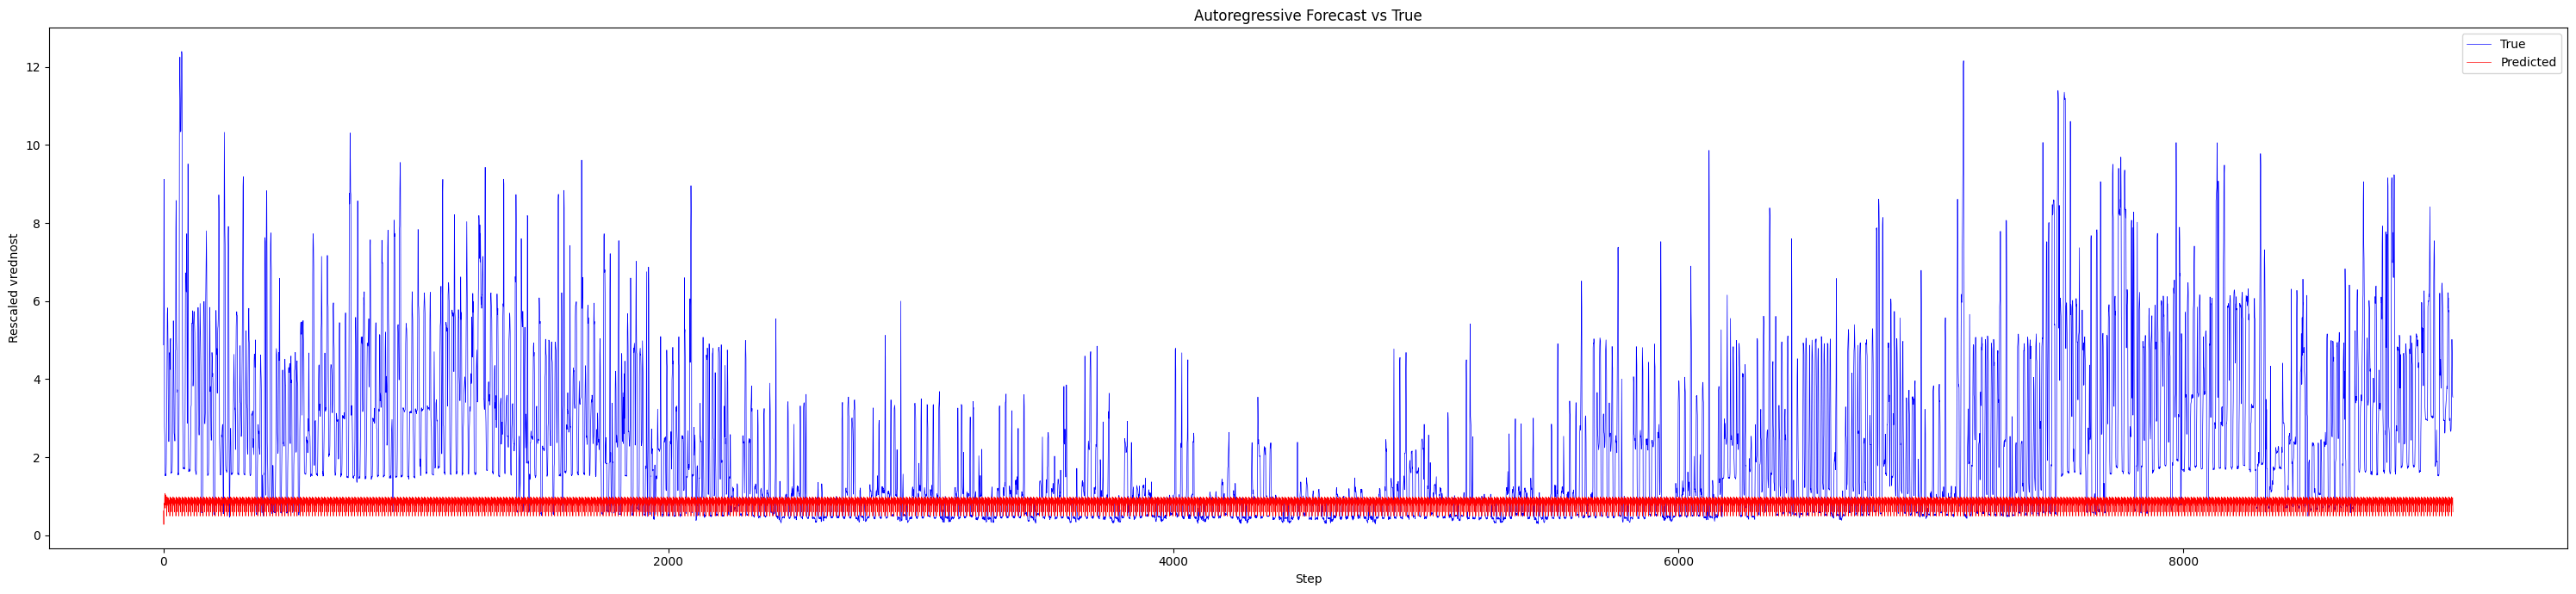

(1.5698583126068115, 0.6425501108169556, 2.413102388381958)

In [23]:
FORECAST_LEN = 12
INPUT_LEN = 24
MODEL_PATH = 'models/model_trial4_lr0.001_clip1_bs128_dropout0_dmodel64_layers4_heads8_kernel4.pth'
model = torch.load(MODEL_PATH)

condition_df = preprocess_all(
    "data/mm79158.csv",
    "data/slovenia_hourly_weather.csv",
    "data/slovenian_holidays_2016_2018.csv"
)

train_loader, val_loader, test_loader, scaler_x, scaler_y = prepare_interformer_dataloaders_and_prediction(
    condition_df,
    input_len=INPUT_LEN,
    forecast_len=FORECAST_LEN,
    batch_size=256
)


autoregressive_evaluate_model(model, val_loader, test_loader, scaler_y, condition_df, forecast_len=FORECAST_LEN)